Table of Contents:
1. Loss Weight Scheduler plots
2. LSP generator

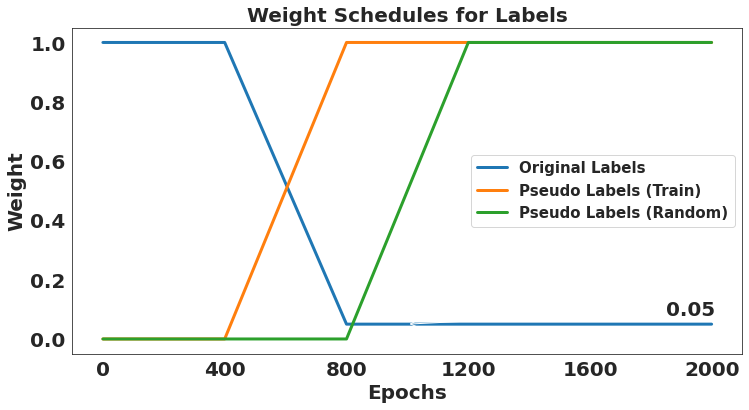

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

lambda_og = lambda epoch: 1 if epoch <= 400 else 1.95 - 0.95/400 * epoch if epoch <= 800 else 0.05
lambda_pseudo_train = lambda epoch: 0 if epoch <= 400 else -1 + epoch/400 if epoch <= 800 else 1
lambda_pseudo_random = lambda epoch: 0 if epoch <= 800 else -2 + epoch/400 if epoch <= 1200 else 1

x = range(2000)
og_values = [lambda_og(v) for v in x]
pseudo_train_values = [lambda_pseudo_train(v) for v in x]
pseudo_random_values = [lambda_pseudo_random(v) for v in x]

sns.set_style("white")  # Set plot style
plt.figure(figsize=(12, 6))  # Set figure size

# Plot the lines
linewidth = 3
og_line = sns.lineplot(x=x, y=og_values, label="Original Labels", linewidth=linewidth) #, color="#DBEDFF")
pseudo_train_line = sns.lineplot(x=x, y=pseudo_train_values, label="Pseudo Labels (Train)", linewidth=linewidth) #,color="#FFEBD6")
pseudo_random_line = sns.lineplot(x=x, y=pseudo_random_values, label="Pseudo Labels (Random)", linewidth=linewidth) #, color="#E8F3E7")

fontsize = 20
plt.annotate("0.05" ,xy=(1000, pseudo_train_line.lines[0].get_ydata()[1000]), xytext=(1850, pseudo_train_line.lines[0].get_ydata()[1000] + 0.03),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.xticks(range(0, 2001, 400), fontsize=fontsize, fontweight="bold")
plt.yticks(fontsize=fontsize, fontweight="bold")
plt.xlabel("Epochs", fontsize=fontsize, fontweight="bold")
plt.ylabel("Weight", fontsize=fontsize, fontweight="bold")
plt.title("Weight Schedules for Labels", fontsize=fontsize, fontweight="bold")
plt.legend(fontsize=15)
plt.savefig("weight_scheduler.png", dpi=300)
plt.show()

2. LSP vector generator

In [1]:
from txgnn import TxGNN, TxEval, TxData, NewDataHandler
from txgnn.utils import *
from tqdm import tqdm
import time
import argparse

split = "complex_disease"
seed = 45
size = 130

TxData1 = TxData(data_folder_path = './data/')
TxData1.prepare_split(split = split, seed = seed, no_kg = False)

Using GPU: NVIDIA RTX A5000
Found local copy...
Found local copy...
Found local copy...
Found saved processed KG... Loading...
Splits detected... Loading splits....
Creating DGL graph....
Done!


In [2]:
TxGNN1 = TxGNN(
        data = TxData1, 
        weight_bias_track = False,
        proj_name = 'TxGNN',
        exp_name = 'TxGNN'
    )
class fake_argparse():
    pass
pseudo_args = fake_argparse()
pseudo_args.all_layer_LSP = False
pseudo_args.pretrain_scores_dict = None
pseudo_args.on_the_fly_KD = False
TxGNN1.model_initialize(n_hid = size, 
                        n_inp = size, 
                        n_out = size, 
                        proto = True,
                        proto_num = 3,
                        attention = False,
                        sim_measure = 'all_nodes_profile',
                        bert_measure = 'disease_name',
                        agg_measure = 'rarity',
                        num_walks = 200,
                        walk_mode = 'bit',
                        path_length = 2,
                        LSP_size="partial",
                        args=pseudo_args
                        )

In [3]:
save_dir = f'pretrained_models/{size}_e2000/{seed}'
TxGNN1.load_pretrained(save_dir)

G = TxGNN1.G.to(TxGNN1.device)
best_G = TxGNN1.best_G.to(TxGNN1.device)
best_model = TxGNN1.best_model.to(TxGNN1.device)
best_model.eval()

## Print out accuracies
neg_sampler = Full_Graph_NegSampler(TxGNN1.G, 1, 'fix_dst', TxGNN1.device)
g_train_neg = neg_sampler(TxGNN1.G)
g_valid_pos, g_valid_neg = TxGNN1.g_valid_pos, TxGNN1.g_valid_neg
g_test_pos, g_test_neg = TxGNN1.g_test_pos, TxGNN1.g_test_neg
## arguments: (model, G, train_pos, train_neg, val_pos, val_neg, test_pos, test_neg, device=None)
accuracies_dict = evaluate_accuracy_per_split(best_model, best_G, g_train_neg, g_valid_pos, g_valid_neg, g_test_pos, g_test_neg)
for k, v in accuracies_dict.items():
    print(f"Accuracy for Positive {k} graph is {v[0].item()}")
    print(f"Accuracy for Negative {k} graph is {v[1].item()}")
print_val_test_auprc(best_model, g_valid_pos, g_valid_neg, g_test_pos, g_test_neg, best_G, TxGNN1.dd_etypes, TxGNN1.device)

Loaded a trained model from path: pretrained_models/130_e2000/45. Could be fully trained or only the pretrain phase
Accuracy for Positive train graph is 0.9341320991516113
Accuracy for Negative train graph is 0.8720200657844543
Accuracy for Positive val graph is 0.47529128193855286
Accuracy for Negative val graph is 0.8563680648803711
Accuracy for Positive test graph is 0.5615196824073792
Accuracy for Negative test graph is 0.8441965579986572
Validation Loss 0.9950,  Validation Micro AUROC 0.7455 Validation Micro AUPRC 0.7546 Validation Macro AUROC 0.7863 Validation Macro AUPRC 0.7921
----- AUROC Performance in Each Relation -----
('drug', 'contraindication', 'disease'): 0.7175645061027708
('drug', 'indication', 'disease'): 0.8550084192757323
----- AUPRC Performance in Each Relation -----
('drug', 'contraindication', 'disease'): 0.720437972818933
('drug', 'indication', 'disease'): 0.8636847093658915
----------------------------------------------
Testing Loss 0.8000 Testing Micro AUROC 

In [4]:
best_G = TxGNN1.G.to(TxGNN1.device)
best_model = TxGNN1.best_model.to(TxGNN1.device)
inter_h, h, beta_kl_loss, distmult = best_model(best_G, pretrain_mode = False, mode = 'train', return_h_and_kl=True, return_all_layer_h=True)
LS_preds = []
for h, sigma in zip([inter_h, h], [0.2, 3]):
    _, _, LS = distmult(best_G, best_G, h, mode=None, pretrain_mode=False, LSP="RBF", LSP_size="partial", sigma=sigma)
    LS_prob = []
    for i, v in enumerate(LS):
        softmaxed = F.softmax(v)
        LS_prob.append(softmaxed)
    LS_preds.append(LS_prob)

time it took to create the sparse tensor: 2.2320377826690674
time it took to create the sparse tensor: 2.2454607486724854


In [8]:
torch.save(LS_preds[1], f"LSP_{size}_{seed}_partial_RBF.pt") ## saves 1 layer LSP
torch.save(LS_preds, f"LSP_{size}_double_{seed}_partial_RBF.pt") ## saves both layer LSP